### Extract functions from LL files

In [1]:
import CodePreprocessing as preprocessing
import json
import re
import os

In [2]:

# ----------------- User functions  --------------------
preprocessing.functions_preprocessing( llvm_file='pairs/UserCode/UserCode.ll', json_file='UserCode' )
with open( 'UserCode.json', 'r' ) as f:
    user_code = json.load(f) 


# ----------------- Vulnerable functions ------------------
# ----------------- Reading all vulnerable codes from the LLVM files

vuln_codes_path= 'pairs/ourVulnCodes/'

# loop on each folder in the path 
for folder in os.listdir(vuln_codes_path):

    if not os.path.exists(vuln_codes_path+folder+'/jsons'):
        os.makedirs(vuln_codes_path+folder+'/jsons')

    # loop on each file in the folder
    for file in os.listdir(vuln_codes_path+folder):
        if file.endswith(".ll"):
            file_name= file.split('.')[0]
            preprocessing.functions_preprocessing( llvm_file=vuln_codes_path+folder+'/'+file, json_file=vuln_codes_path+folder+'/jsons/'+file_name )


# ----------------- Reading all vulnerable codes from the JSON files and save it in a dictionary
vulnerable_code= dict()

for folder in os.listdir(vuln_codes_path):

    # make dictionary for the folder with its name as the key 
    vulnerable_code[folder]= dict()
    
    for file in os.listdir(vuln_codes_path+folder+'/jsons'):
        if file.endswith(".json"):
            with open( vuln_codes_path+folder+'/jsons/'+file, 'r' ) as f:
                vulnerable_code[folder].update(json.load(f)) 

### Matching

In [8]:
import matchers as matcher
import LLNormalizer as normalizer
import Winnowing
import heapq
import time

In [9]:
def check_function_vulnerable(threshold,score1,score2,score3):
    return score1 > threshold and score2 > threshold and score3 > threshold

In [20]:
#applying KNN but with similarity measures, we take the top 3 scores in all similarity measures, if those top 3 passed the threshold, we do the ultimate test, MOSS.
#K here equals 3

threshold = 0.7
k = 3

#this is a dictionary of key: 
#                       dictionary of key: vulnerability family 
#                           and its value: dictionary of key: vulnerable function (which is in our database) and 
#                                                             code_scores for this vulnerable function (and the User Function)
Vulnerable_Matches = {}

for vuln_family, vuln_funcs in vulnerable_code.items():
    print("Vulnerable Family: ", re.findall(r'\d+', vuln_family))
    times= []

    for vuln_head, vuln_func in vuln_funcs.items():
        code_scores = {}

        for key, fn in user_code.items():
            start = time.time()
            jaro_winkler = matcher.jaro_winkler_similarity(fn, vuln_func)
            levenshtein = matcher.levenshtein_similarity(fn, vuln_func)
            ratcliff_obershelp = matcher.ratcliff_obershelp_similarity(fn, vuln_func)
            trigram = matcher.trigram_similarity(fn, vuln_func)
            sorensen_dice = matcher.sorensen_dice_similarity(fn, vuln_func)
            jaccard_distance = matcher.jaccard_distance(fn, vuln_func)
            end = time.time()
            times.append(end-start)

            scores = [jaro_winkler, ratcliff_obershelp,levenshtein, trigram, sorensen_dice, jaccard_distance]
            scores = heapq.nlargest(6, scores)
            code_scores[key] = scores

        if code_scores:
            Vulnerable_Matches.setdefault(vuln_family, {})[vuln_head] = code_scores

with open('code_scores.json', 'w') as f:
    json.dump(Vulnerable_Matches, f, indent=4)

Vulnerable Family:  ['23']


Average time for sorting:  0.027977127399560604


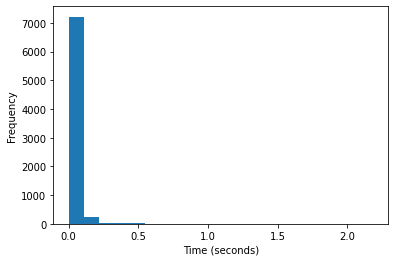

In [ ]:
print("Average time for sorting: ", sum(times)/len(times))
#plotting the time for sorting
import matplotlib.pyplot as plt
plt.hist(times, bins=20)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.show()

# MOSS

In [ ]:
#Candidate_Functions is a list of tuples, each containing a possible Match. A Match means User Function matching a Vulnerable Function
Candidate_Functions = []
for vuln_family, vuln_funcs in vulnerable_code.items():

    print("The Family: ", re.findall(r'\d+', vuln_family))

    found_vuln = False
    
    for vuln_head, vuln_func in vuln_funcs.items():

        #Normalizing the vulnerable function with us (not user code)
        normalizedvuln = normalizer.NormalizeLLVM(vuln_func)

        #for each function passing the threshold, do MOSS.
        for user_function in Vulnerable_Matches[vuln_family][vuln_head]:
            code_scores = Vulnerable_Matches[vuln_family][vuln_head]
            
            if check_function_vulnerable(threshold,code_scores[user_function][0],code_scores[user_function][1],code_scores[user_function][2]):
                fn = user_code[user_function]

                #sometimes normalizing behaves good, sometimes bad.
                normalizedfn = normalizer.NormalizeLLVM(fn)
                    
                #MOSS Metrics (defined in Winnowing.py), Parameters passed: k=20, ws = 10, P=10
                MOSS_Acc_metric1, MOSS_Acc_metric2, hits, misses1, misses2 = Winnowing.diff(normalizedfn, normalizedvuln, K= 20, WindowSize= 10, P= 10)
                
                print("\n\nVulnerable function found:",user_function)

                #MOSS Thresholds, 0.7 for Metric1, 0.7 for Metric2, those thresholds are highly dependent on the vulnerability type unfortunately.
                if(MOSS_Acc_metric1>0.7 or MOSS_Acc_metric2>0.7):
                    print(f"MOSS Caught this <3 !!!")
                    print(f"Accuracy_Metric 1 = {MOSS_Acc_metric1}  ||  Accuracy_Metric 2 = {MOSS_Acc_metric2}\nhits: {hits} , misses: {misses1}, misses2: {misses2}")
                    found_vuln = True

                    #Candidate_Functions containg a tuple of (original function head, vulnerable function name (which is stored with us))
                    Candidate_Functions.append((re.findall('(@.*)\(', user_function)[0]  ,  re.findall('(@.*)\(', vuln_head)[0]))
                    print("Candidate_Functions: ", Candidate_Functions)

                print('-----------------------')

        if found_vuln:
            break

The Family:  CWE114


Vulnerable function found: define void @"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"() local_unnamed_addr { CVE23, 

MOSS Caught this <3 !!!
Accuracy_Metric 1 = 1.0  ||  Accuracy_Metric 2 = 0.5
hits: 12445 , misses: 0, misses2: 12445
Candidate_Functions:  [('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_04::bad"')]
-----------------------
The Family:  CWE23


Vulnerable function found: define void @"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"() local_unnamed_addr { CVE23, 

MOSS Caught this <3 !!!
Accuracy_Metric 1 = 1.0  ||  Accuracy_Metric 2 = 0.5
hits: 12445 , misses: 0, misses2: 12445
Candidate_Functions:  [('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_04::bad"'), ('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relati

In [ ]:
for i in Candidate_Functions:
    print(i)

('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_04::bad"')
('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_04::bad"')
Number of candidate functions:  2


# Graph matching ان شاء الله

In [ ]:
import graph
import os
import re
from subprocess import run
import pathlib
import json

#Path to Marim's script generate_subgraphs.py
absPathtoCFGScript = str(os.path.abspath("../../IrToCFGs/generate_subgraphs.py")).replace("\\", "/")
absPathtoCFGScript = list(absPathtoCFGScript)
absPathtoCFGScript[0] = absPathtoCFGScript[0].upper()
absPathtoCFGScript = ''.join(absPathtoCFGScript)


#Path to the pairs folder in this directory
absPathtoPairsFolder = (str(os.getcwd())+"/pairs").replace("\\", "/")
absPathtoPairsFolder = list(absPathtoPairsFolder)
absPathtoPairsFolder[0] = absPathtoPairsFolder[0].upper()
absPathtoPairsFolder = ''.join(absPathtoPairsFolder)

#run CFG script on all subfolders inside pairs folder
run(["python",absPathtoCFGScript, "0", absPathtoPairsFolder , absPathtoPairsFolder])

CompletedProcess(args=['python', 'D:/Guardista/IrToCFGs/generate_subgraphs.py', '0', 'D:/Guardista/Localizer/Common/pairs', 'D:/Guardista/Localizer/Common/pairs'], returncode=0)

In [ ]:
#Prepare graphs for Vulnerable code, precompute them and store them in a list
#Vulnerable code (we are storing) is put inside a folder called ourVulnCodes, and the corresponding CFGs is inside a folder called ourVulnCodes_subgraphs/VulnerableCode_subgraphs
VulnerableCodeSubgraphsFolder = absPathtoPairsFolder + "/ourVulnCodes_subgraphs/"

#List containing graphs of each precomputed Vulnerable Code
ourGraphs = []

for currentpath, folders, jsonfiles in os.walk(VulnerableCodeSubgraphsFolder):

    for jsonfile in jsonfiles:
        fulljsonFilePath = currentpath+'/'+jsonfile
       
        with open(fulljsonFilePath) as f:
            jsonDict= json.load(f)
        
        functionName = jsonDict["function_name"].replace('\\', '')
        newGraph = graph.Graph()
        newGraph.readGraphFromJSON(fulljsonFilePath)
        ourGraphs.append(newGraph)

In [ ]:
'''
we are trying to find the json file containing the name of the candidate functions (we will not compute CFG of EVERY possible function, rather just the candidate functions),
if we found a json of a candidate function, we compute its graph and perform the matching.

candidate functions are the functions that passed MOSS
'''


UserCodeSubgraphsFolder = absPathtoPairsFolder + "/UserCode_subgraphs/UserCode_subgraphs"

final_Matched_Functions = []

allFiles = os.listdir(UserCodeSubgraphsFolder)
for jsonfile in allFiles:
    fulljsonFilePath = UserCodeSubgraphsFolder+'/'+jsonfile
    if(pathlib.Path(jsonfile).suffix != ".json"):
        continue
    with open(fulljsonFilePath) as f:
        jsonDict = json.load(f)
    functionName = jsonDict["function_name"].replace('\\', '')

    if(functionName in [i[0] for i in Candidate_Functions]):              #check if the function name is inside Candidate Functions
        #Construct User Graph and Perform Matching
        UserCodeGraph = graph.Graph()
        UserCodeGraph.readGraphFromJSON(fulljsonFilePath)
        MatchPairs = graph.matchGraphWithListOfGraphs(UserCodeGraph , ourGraphs, otherWayAround=True)
        
        #MatchPairs is a list of Tuples, each Tuples contains the UserFunction Name and the Function Name stored in our Database
        if(MatchPairs):
            final_Matched_Functions.append(MatchPairs)

# Final Matches الحمد لله

In [ ]:
print(final_Matched_Functions)
# NOTICE NO FALSE POSITIVES NOR FALSE NEGATIVES <3 <3 <3

[[('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_04::bad"'), ('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_04::bad"'), ('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_06::bad"'), ('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_06::bad"'), ('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_09::bad"'), ('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_09::bad"'), ('@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_01::bad"', '@"CWE23_Relative_Path_Traversal__char_connect_socket_fopen_13

In [ ]:

#Cleanup

import os
files = os.listdir('./')
files = [ fi for fi in files if fi.endswith(".json")]
for f in files:
    os.remove(f)


In [ ]:
import highlighter
import os
import re

srcFiles = os.listdir("../../temp/source")
print(srcFiles)

for src in srcFiles:
    currentPath = str(os.getcwd()).replace('\\', '/')
    
    currentPath = re.split(r"/" ,currentPath)[:-2]
    print(currentPath)
    srcFilePath = currentPath+ ['temp','source',src]
    print(srcFilePath)
    srcFilePath = '/'.join(srcFilePath)
    print(srcFilePath)

    for func,_ in final_Matched_Functions:
        highlighter.getMatchingLines(srcFilePath, func)